In [1]:
import sys
sys.path.append('..')
import quarantines as Q
import quarantines_mongo as qm
import graph_generators as gg 
import networkx as nx 
import networkit as nk
import pymongo
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from tabulate import tabulate
from scipy import stats
import pprint
sns.set()

In [2]:
"""
General notebook to read/play around with data and figure out which experiments to run
Will do the following 4 things: 
1) V_graphs by name: V([names,...], [I,R]): plots V graphs normalized by graph size for graphs by name 
2) Graph_stats_reader : Read the Avg-degree, cluster-coefficient, scale parameter for these graphs 
3) Graph_stats_singleQ: read the (prop, value) for {maxI, finalR} by name and print 
4) Plot by ^ for these things 
"""
print()

In [20]:
# Part 0: Collect data by name and print all names...

def gather_data():
    data_file = open('../quarantine_by_props_1016A.pkl', 'rb')
    data = pickle.load(data_file)
    data_by_name = {}
    for datum in data:
        name = datum.get('name')
        if name not in data_by_name:
            data_by_name[name] = [] 
        data_by_name[name].append(datum)
    return data_by_name

def group_by_qprop(series):
    gather = {} 
    for datum in series:
        qprop = datum['quarantine_props']
        if qprop not in gather:
            gather[qprop] = [] 
        gather[qprop].append(datum)
        
    # and now modify to only collect final_R, max_I
    output = {}
    for qprop, datalist in gather.items():
        final_rs = [_['final_R'] for _ in datalist]
        max_is = [_['max_I'] for _ in datalist]
        output[qprop] = {'final_R': final_rs, 
                         'max_I': max_is}
    return output

def gather_by_name(data, name, i_or_r):
    # Gather triples of [(qprop, mean, std), ...]
    assert i_or_r in ['I', 'R']
    series = group_by_qprop(data[name])
    output = []
    def getter(doc):
        if i_or_r == 'I':
            return doc['max_I']
        else:
            return doc['final_R']
        
        
    for k, v in series.items():
        mean = np.mean(getter(v))
        std = np.std(getter(v))
        output.append((k, mean, std))
        
    return sorted(output, key=lambda trip: trip[0])
    

def size_lookup_by_name(name):
    if name in SYNTHETICS:
        return 10 ** 4 
    elif name.startswith('fb.'):
        return len(gg.load_gemsec_fb(name.split('.')[1]))
    elif name.startswith('deezer.'):
        return len(gg.load_gemsec_deezer(name.split('.')[1]))
    elif name.startswith('arxiv.'):
        return len(gg.load_arxiv_collab(name.split('.')[1]))
    elif name.startswith('hiv') or name.startswith('hs'):
        G = recreate_by_name(name)
        return len(G)
    
    
def recreate_by_name(name):
    # Don't worry too much about actual random seed, just gather parameters
    if name.startswith('ba'):
        return gg.ba_graph(10 ** 4, int(name[2:]))
    elif name.startswith('plc'):
        m, p = name[3:].split('.')
        return gg.plc_graph(10 **4, int(m), float(p) / 100)
    elif name.startswith('rw'):
        assert name == 'rw.91.94'
        return gg.random_walk_graph(10 ** 4, 0.91, 0.94)
    elif name.startswith('nn'):
        assert name == 'nn.886'
        return gg.nearestNeighbor_mod(10 **4, 0.88,6)
    elif name.startswith('ws'):
        assert name == 'ws10.05'
        return gg.watts_strogatz_graph(10 ** 4, 10, 0.05)
    elif name.startswith('fb.'):
        return gg.load_gemsec_fb(name.split('.')[1])
    elif name.startswith('deezer.'):
        return gg.load_gemsec_deezer(name.split('.')[1])
    elif name.startswith('arxiv.'):
        return gg.load_arxiv_collab(name.split('.')[1])
    elif name.startswith('hs'):
        params = name[2:].split('_')
        return gg.load_highschool(float(params[0]), int(params[1]))
    elif name.startswith('hiv'):
        param = int(name[3:].split('R')[0])
        return gg.load_hiv(param)
    else:
        raise Exception("wut")
    return
    
    
def parse_data_name(name):
    prefixes = ['ba', 'plc', 'nn', 'rw', 'ws' ]
    match = None
    for prefix in prefixes:
        if name.startswith(prefix):
            match = prefix 
    if match is None or len(name.split('_')) == 1:
        return recreate_by_name(name)
    params = name.split('_')
    R = params[-1]
    if name.startswith('ba'):
        return gg.ba_graph(10 ** 4, int(params[1]))
    elif name.startswith('plc'):
        return gg.plc_graph(10 **4, int(params[1]), float(params[2]))
    elif name.startswith('rw'):
        return gg.random_walk_graph(10 ** 4, float(params[1]), float(params[2]))
    elif name.startswith('nn'):
        return gg.nearestNeighbor_mod(10 **4, float(params[1]),int(params[2]))
    elif name.startswith('ws'):
        return gg.watts_strogatz_graph(10 ** 4, int(params[1]), float(params[2]))

    
def get_r_by_name(name):
    prefixes = ['ba', 'plc', 'nn', 'rw', 'ws' ]
    match = None
    for prefix in prefixes:
        if name.startswith(prefix):
            match = prefix 
    if match is None or len(name.split('_')) == 1:
        return 1
    params = name.split('_')
    return float(params[-1])



def get_minR_graph(data, name):
    # Gathers the graph (after minR optimal quarantine) 
    # 1) Get minR prop:
    minprop = min(gather_by_name(data, name, 'R'), key=lambda trip: trip[1])[0]
    
    
    # 2) Recreate graph and rerun 
    R = get_r_by_name(name)
    G = parse_data_name(name)
    outG = Q.run_until_prop_IR(G, R, 1, 10 / len(G), float('inf'), minprop)[0]
    return outG


In [19]:
min(gather_by_name(data, 'ba_10_0.', 'R'), key=lambda trip: trip[1])[0]

0.38

In [4]:
data = gather_data()
SYNTHETICS = ['ba10', 'ba5', 'plc10.25', 'plc5.5', 'rw.91.94', 'nn.886', 'ws10.05',]
EPIS = [_ for _ in data if (_.startswith('hs') or _.startswith('hiv'))]
REALS = [_ for _ in data if _ not in SYNTHETICS]
#size_lookup = {k: size_lookup_by_name(k) for k in data}

In [6]:
sorted(data.keys())

['arxiv.AstroPh',
 'arxiv.CondMat',
 'arxiv.GrQc',
 'arxiv.HepPh',
 'arxiv.HepTh',
 'ba10',
 'ba5',
 'ba_10_0.03125',
 'ba_10_0.0625',
 'ba_10_0.125',
 'ba_10_0.25',
 'ba_10_0.5',
 'ba_10_1',
 'ba_10_2',
 'ba_10_4',
 'ba_10_8',
 'ba_5_0.03125',
 'ba_5_0.0625',
 'ba_5_0.125',
 'ba_5_0.25',
 'ba_5_0.5',
 'ba_5_1',
 'ba_5_2',
 'ba_5_4',
 'ba_5_8',
 'deezer.HR',
 'deezer.HU',
 'deezer.RO',
 'fb.artist',
 'fb.athletes',
 'fb.company',
 'fb.government',
 'fb.new_sites',
 'hiv50R1',
 'hiv50R3',
 'hiv50R5',
 'hs15_10',
 'hs30_10',
 'hs5_10',
 'hs60_10',
 'nn.886',
 'nn_0.88_6_0.03125',
 'nn_0.88_6_0.0625',
 'nn_0.88_6_0.125',
 'nn_0.88_6_0.25',
 'nn_0.88_6_0.5',
 'nn_0.88_6_1',
 'nn_0.88_6_2',
 'nn_0.88_6_4',
 'nn_0.88_6_8',
 'plc10.25',
 'plc5.5',
 'plc_10_0.25_0.03125',
 'plc_10_0.25_0.0625',
 'plc_10_0.25_0.125',
 'plc_10_0.25_0.25',
 'plc_10_0.25_0.5',
 'plc_10_0.25_1',
 'plc_10_0.25_2',
 'plc_10_0.25_4',
 'plc_10_0.25_8',
 'plc_5_0.5_0.03125',
 'plc_5_0.5_0.0625',
 'plc_5_0.5_0.125',
 'pl

In [ ]:
for el in sorted(data.keys()):
    print(el)

In [ ]:
plcs_rs = '''plc_10_0.25_0.03125
plc_10_0.25_0.0625
plc_10_0.25_0.125
plc_10_0.25_0.25
plc_10_0.25_0.5
plc_10_0.25_1
plc_10_0.25_2
plc_10_0.25_4
plc_10_0.25_8'''.split('\n')

In [ ]:
plc2='''plc_5_0.5_0.03125
plc_5_0.5_0.0625
plc_5_0.5_0.125
plc_5_0.5_0.25
plc_5_0.5_0.5
plc_5_0.5_1
plc_5_0.5_2
plc_5_0.5_4
plc_5_0.5_8'''.split('\n')

In [ ]:
REALS

In [ ]:

def degree_hist(G):
    pairs = {}
    for _, d in G.degree():
        pairs[d] = pairs.get(d, 0) + 1
    return pairs


def get_powerlaw_exponent_cbin(G):
    # Returns best-fit powerlaw exponent by using cumulative binning 
    items = sorted(degree_hist(G).items(), key=lambda p:-p[0])
    cdf = []
    runsum = 0
    for deg, num in items:
        runsum += num 
        cdf.append((deg, runsum))
    xform = [(np.log(_[0]), np.log(_[1] / len(G))) for _ in cdf]
    #plt.scatter(*zip(*xform))
    slope, intercept, r_value, p_value, std_err = stats.linregress(*zip(*xform))
    return 1 -slope

        
def collect_graph_data_by_name(name, data=data):
    # Returns graph [name, nodes, average degree, cluster coefficient, powerlaw exponent, best_iTup, bestrTup] 
    G = recreate_by_name(name)
    nodes = len(G)
    avg_deg = sum(dict(G.degree()).values()) / len(G)
    cc = nx.average_clustering(G)
    powerlaw = get_powerlaw_exponent_cbin(G)
    no_q = gather_by_name(data, name, 'R')[0][1] /len(G)
    best_i = min(gather_by_name(data, name, 'I'), key=lambda tri: tri[1])
    best_i_prop = best_i[0]
    best_i_val = best_i[1] / nodes
    best_r = min(gather_by_name(data, name, 'R'), key=lambda tri: tri[1])
    best_r_prop = best_r[0]
    best_r_val = best_r[1] / nodes
    return [name, nodes, avg_deg, cc, powerlaw, no_q, best_r_prop, best_r_val]


def tabulate_by_name(names):
    headers=['name', 'nodes', 'avg_deg', 'cc', 'powerlaw', 'no_Q', 'best_r_prop', 'best_r_val']
    graph_data = [collect_graph_data_by_name(_) for _ in names]
    print(tabulate(graph_data, headers=headers, floatfmt='.2f'))
    return graph_data

In [ ]:
synth_rows = tabulate_by_name(SYNTHETICS)

In [27]:
#fig, ax = plt.subplots(figsize=(10,10)) #<---- general axis maker
def plot_vs(data, names, irs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))
    if not isinstance(names, list):
        names = [names]
    def plot_single_v(name, ir, ax=ax):
        try:
            size = size_lookup[name]
        except:
            size = 1e4
        i_trips = gather_by_name(data, name, 'I')
        r_trips = gather_by_name(data, name, 'R')
        qprops = [_[0] for _ in i_trips]
        Is = [_[1] / size for _ in i_trips]
        qprops_r = [_[0] for _ in r_trips]
        Rs = [_[1] / size for _ in r_trips]
        if 'I' in ir:
            ax.plot(qprops, Is, label=name)
        if 'R' in ir:
            ax.plot(qprops, Rs, label=name)
    
    
    for name in names:
        plot_single_v(name, irs, ax=ax)
    ax.legend()

In [ ]:
#fig, ax = plt.subplots(figsize=(10,10)) #<---- general axis maker
def plot_vs(data, names, irs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))
    if not isinstance(names, list):
        names = [names]
    def plot_single_v(name, ir, ax=ax):
        size = 10 **4 # size_lookup[name]
        i_trips = gather_by_name(data, name, 'I')
        r_trips = gather_by_name(data, name, 'R')
        qprops = [_[0] for _ in i_trips]
        Is = [_[1] / size for _ in i_trips]
        qprops_r = [_[0] for _ in r_trips]
        Rs = [_[1] / size for _ in r_trips]
        if 'I' in ir:
            ax.plot(qprops, Is, label=name)
        if 'R' in ir:
            ax.plot(qprops, Rs, label=name)
    
    
    for name in names:
        plot_single_v(name, irs, ax=ax)
    ax.legend()
    return ax

In [ ]:
ax = plot_vs(data, plcs_rs, 'R')
ax.plot([0.0, 1.0], [0.0, 1.0], linestyle='dashed', alpha=0.8, c='grey', label='Pop. Average')


In [ ]:
ax = plot_vs(data, plc2, 'R')
ax.plot([0.0, 1.0], [0.0, 1.0], linestyle='dashed', alpha=0.8, c='grey', label='Pop. Average')


In [ ]:
nns = '''nn_0.88_6_0.03125
nn_0.88_6_0.0625
nn_0.88_6_0.125
nn_0.88_6_0.25
nn_0.88_6_0.5
nn_0.88_6_1
nn_0.88_6_2
nn_0.88_6_4
nn_0.88_6_8'''.split('\n')

In [ ]:
ax = plot_vs(data, nns, 'R')
ax.plot([0.0, 1.0], [0.0, 1.0], linestyle='dashed', alpha=0.8, c='grey', label='Pop. Average')


In [ ]:
plot_vs(data, [_ for _ in EPIS if _.startswith('hs')], 'R')
print([_ for _ in EPIS if _.startswith('hs')])

In [ ]:
tabulate_by_name(['ba10', 'ba5'])

In [ ]:
synth_data = [collect_graph_data_by_name(_) for _ in SYNTHETICS]
print(tabulate(synth_data, headers=['name', 'nodes', 'avg_deg', 'cc', 'powerlaw', 'best_i', 'best_r']))

In [ ]:
real_data = [collect_graph_data_by_name(_) for _ in REALS]
print(tabulate(real_data, headers=['name', 'nodes', 'avg_deg', 'cc', 'powerlaw', 'best_i', 'best_r'], 
               floatfmt=".2f"))

In [ ]:
hiv_vanilla = gg.load_hiv()
print(len(hiv_vanilla))

In [ ]:
qprops = [_ / 100 for _ in range(100)]
hiv_data = {}
for qprop in qprops:
    print(qprop)
    hiv_data[qprop] = Q.quarantine_by_prop(hiv_vanilla, 0.1, 0.1, 5 / len(hiv_vanilla), [qprop], float('inf'), num_iter=100)

In [ ]:
def get_vs_now(data_dict, irs):
    

In [ ]:
hs_dict = {_: gg.load_highschool(_, scale=1) for _ in [0, 5, 15, 30, 60]}

In [ ]:
plt.hist(dict(hs_dict[15].degree()).values(), bins=25)

In [ ]:
print(SYNTHETICS)

In [ ]:
tabulate_by_name(['ba10', 'ba5'])

In [ ]:
tabulate_by_name(SYNTHETICS)

In [ ]:
tabulate_by_name(REALS)

In [ ]:
real_str = '''name             nodes    avg_deg    cc    powerlaw    best_i_prop    best_i_val    best_r_prop    best_r_val
-------------  -------  ---------  ----  ----------  -------------  ------------  -------------  ------------
fb.artist        50517      32.44  0.14        2.64           0.28          0.28           0.59          0.61
fb.athletes      13868      12.53  0.28        2.85           0.24          0.23           0.48          0.52
fb.company       14115       7.41  0.24        2.97           0.17          0.16           0.36          0.40
fb.new_sites     27919      14.78  0.30        2.85           0.25          0.24           0.55          0.57
fb.government     7059      25.35  0.41        2.58           0.29          0.28           0.65          0.68
deezer.RO        41775       6.02  0.09        3.70           0.20          0.17           0.47          0.49
deezer.HR        54575      18.26  0.14        3.39           0.31          0.30           0.66          0.71
deezer.HU        47540       9.38  0.12        3.79           0.27          0.25           0.61          0.64
arxiv.AstroPh    18772      21.11  0.63        2.83           0.25          0.24           0.48          0.53
arxiv.CondMat    23133       8.08  0.63        3.11           0.18          0.17           0.37          0.40
arxiv.HepPh      12008      19.74  0.61        2.31           0.20          0.19           0.42          0.44
arxiv.GrQc        5242       5.53  0.53        2.88           0.12          0.10           0.22          0.28
arxiv.HepTh       9877       5.26  0.47        3.28           0.14          0.12           0.31          0.32
hiv50R1          10327       2.29  0.06        2.68           0.02          0.01           0.02          0.03
hiv50R3          10172       2.28  0.07        2.67           0.11          0.08           0.18          0.25
hiv50R5          10489       2.26  0.07        2.67           0.15          0.13           0.28          0.34
hs5_10            7850      61.69  0.12        2.09           0.43          0.43           0.88          0.89
hs15_10           7590      38.85  0.11        2.31           0.42          0.41           0.86          0.87
hs30_10           7320      21.65  0.08        2.52           0.39          0.37           0.79          0.81
hs60_10           6408       5.59  0.04        3.02           0.25          0.19           0.55          0.60'''

In [ ]:
buffer = '-' * 109
split_str = real_str.split('\n')
sort_str = split_str[:2] 
sortkey = lambda line: float(line.split(' ')[-1])
sort_str = sort_str + sorted(split_str[2:], key=sortkey)

# first sort by best r 

# then add '-' buffers 
output_str = [] 
for line in sort_str:
    output_str.append(line)
    #output_str.append(buffer)
print('\n'.join(output_str))

In [ ]:
sort_str

In [ ]:
G = gg.ba_graph(10 ** 4, 10)
Q.plot_vanilla_run(G, 0.125 / 2, 1, 10 / len(G), float('inf'), num_iter=3)

In [24]:
plcs = [_ for _ in sorted(data.keys()) if _.startswith('plc_5_0.5')]

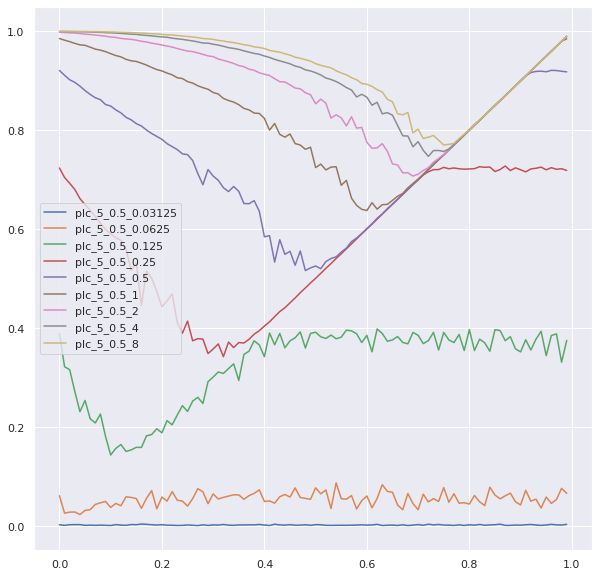

In [42]:

plot_vs(data, plcs, 'R')